# All the Library imports

In [1]:
import mimetypes
from pathlib import Path
import os
import sys
import random
import shutil
from tempfile import TemporaryDirectory
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import torch as tc
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import albumentations as A
import torch.nn as nn
from tqdm.notebook import trange, tqdm

# Data Aquisition

### Clone the github repo to get all the data we have collected

In [2]:
dataDir = TemporaryDirectory(dir='/content/sample_data', prefix='github_')
!git clone https://github.com/waruna-wickramasingha/landmark-detection.git $dataDir.name
!git -C $dataDir.name/landmarks checkout feature/datarestructure

Cloning into '/content/sample_data/github_9ioz8z3f'...
remote: Enumerating objects: 1951, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1951 (delta 10), reused 44 (delta 10), pack-reused 1907
Receiving objects: 100% (1951/1951), 1.95 GiB | 44.72 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (1663/1663), done.
Updating files: 100% (3330/3330), done.
Branch 'feature/datarestructure' set up to track remote branch 'feature/datarestructure' from 'origin'.
Switched to a new branch 'feature/datarestructure'


In [3]:
def getFilesList(path: str, desiredExtensionList, recursion=False):
  fileList = []
  path = Path(path)
  if recursion == False:
    for x in path.iterdir():
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  else:
    for x in path.glob('**/*'):
      if x.suffix.lower() in desiredExtensionList:
        fileList.append(x)
  return fileList

In [4]:
def getImageNameToClassMap(annotationsDir:str):
  aggrImageNameToClassMap = dict()
  annotationsDir = Path(annotationsDir)
  try:
    for x in annotationsDir.iterdir():
      if x.suffix.lower() == ".json":
        with open(x, 'r') as f:
          annotationDict = json.load(f)
          annList = list(map(dict, annotationDict.values()))
          image_name_to_class_map = { it['filename'] : it['regions'][0]['region_attributes']['class'].lower() for it in annList }
          aggrImageNameToClassMap.update(image_name_to_class_map)
  except:
    raise Exception("Failed to aggregate annotated json files")
  finally:
    print("Annotation files aggragated successfully!")
  return aggrImageNameToClassMap

In [5]:
im_name_to_class = getImageNameToClassMap(dataDir.name + '/annotations')
len(im_name_to_class)

Annotation files aggragated successfully!


1655

In [6]:
all_classes = set(im_name_to_class.values())
all_classes

{'aldi wallisdown',
 'aniba',
 'art studios',
 'arts bar',
 'arts bu library',
 'asda',
 'ashley automotive',
 'auds',
 'aush',
 'auss',
 'autg',
 'baboo ji',
 'bailey point',
 'beales',
 'bellaton house',
 'block a and block b arts university',
 'bobbys',
 'bournemouth and poole college',
 'bournemouth gateway building',
 'bu executive business centre',
 'bu international college',
 'bu lansdowne',
 'bu student house',
 'buch',
 'burley court hotel',
 'buta',
 'buth',
 'careers center',
 'cbd flower shop',
 'church',
 'coop store',
 'court royal',
 'courtleigh manor',
 'cranborne house',
 'design and engineering innovation center',
 'dorchester house',
 'dorset house',
 'east cliff urc church',
 'enterprise house',
 'fairways care home',
 'fern arrow roundabout',
 'fusion building',
 'gorscliff court',
 'hilton',
 'home park',
 'hot rocks',
 'iq building',
 'jakey house',
 'kimmeridge house',
 'lester aldridge',
 'lidl bournemouth',
 'lush',
 'mccarthy stone head office',
 'minton lod

In [7]:
len(all_classes)

100

In [8]:
for k,v in im_name_to_class.items():
  if v == '':
    print(k)

In [9]:
beforeAugImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='BeforeAugmentation_')
testImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Test_')

## Re-arrange data into train and test sets using 75% trainig split 

In [10]:
image_extensions = [k for k,v in mimetypes.types_map.items() if 'image/' in v]
random.seed(13)

def reArrangeImagesIntoTrainTest(lm_dir:str, trainDir:str, testDir:str, trainSplit=0.75):
  """
  This method would split the original list of images provided in imagesList 
  by moving them into trainDir and testDir keeping the original file name.
  """
  global image_extensions
  imagesList = getFilesList(lm_dir, image_extensions)
  imagesList = np.array(imagesList)
  randSelections = np.random.permutation(len(imagesList))

  trainTestCutPoint = int(len(imagesList)*trainSplit)
  trainImages = imagesList[randSelections[:trainTestCutPoint]]
  testImages = imagesList[randSelections[trainTestCutPoint:]]

  lm_dir_name = lm_dir.split(os.sep)[-1]

  try:
    #Re-arrange train images
    lm_train_dir = TemporaryDirectory(dir=trainDir, prefix=lm_dir_name)
    print("Creating Train directory={}".format(lm_train_dir.name))
    for p in trainImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_train_dir.name + os.sep + imageName
      shutil.move(p, newPath)

    #Re-arrange test images
    lm_test_dir = TemporaryDirectory(dir=testDir, prefix=lm_dir_name)
    print("Creating Test directory={}".format(lm_test_dir.name))
    for p in testImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = lm_test_dir.name + os.sep + imageName
      shutil.move(p, newPath)
  except:
    raise Exception("Failed to move images into train={} and test={} directories".
                    format(lm_train_dir.name, lm_test_dir.name))
  return (lm_train_dir, lm_test_dir)

In [11]:
landmarks_dir = Path(dataDir.name+os.sep+'landmarks')
tempdirs = []
for lm in landmarks_dir.glob('**/'):
  if lm == landmarks_dir:
    continue
  print("\n Original direcotry={}".format(lm))
  tempdirs.append(reArrangeImagesIntoTrainTest(str(lm), beforeAugImagesRoot.name, testImagesRoot.name, 0.75))

Original direcotry=/content/sample_data/github_9ioz8z3f/landmarks/Slug
Creating Train directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Slugdttiv4e7
Creating Test directory=/content/sample_data/Test_gqm9xk8e/Slugk_9pd0xl
Original direcotry=/content/sample_data/github_9ioz8z3f/landmarks/Beales
Creating Train directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Bealesr1t1xu9y
Creating Test directory=/content/sample_data/Test_gqm9xk8e/Beales6xia9p17
Original direcotry=/content/sample_data/github_9ioz8z3f/landmarks/Bournemouth Gateway Building
Creating Train directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Bournemouth Gateway Buildingpjy246im
Creating Test directory=/content/sample_data/Test_gqm9xk8e/Bournemouth Gateway Buildingib7avezf
Original direcotry=/content/sample_data/github_9ioz8z3f/landmarks/BU Tolpuddle Annex-1
Creating Train directory=/content/sample_data/BeforeAugmentation_y5qf79o2/BU Tolpuddle Annex-139ldnrpr
Creating Test directory=/content/sample_da

In [12]:
getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8043.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8044.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8047.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8054.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8050.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8053.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8041.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4/IMG_8034.JPG'),
 PosixPath('/content/sample_data/BeforeAugmentation_y5qf79o2/Bournemouth Gateway Buildingpjy246im/Bournemouth Gateway Building_20.JPG'),
 PosixPath('/content/sample_data/BeforeAugmenta

In [13]:
getFilesList(testImagesRoot.name, image_extensions, recursion=True)

[PosixPath('/content/sample_data/Test_gqm9xk8e/Skyline Accomodationy5ipptr2/20230326_154129.jpg'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/Skyline Accomodationy5ipptr2/20230402_182900.jpg'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/Skyline Accomodationy5ipptr2/20230326_154121.jpg'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/Skyline Accomodationy5ipptr2/20230326_154048.jpg'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/design and engineering innovation center91sixmng/IMG_7788.JPG'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/design and engineering innovation center91sixmng/IMG_7795.JPG'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/design and engineering innovation center91sixmng/IMG_7789.JPG'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/design and engineering innovation center91sixmng/IMG_7794.JPG'),
 PosixPath('/content/sample_data/Test_gqm9xk8e/design and engineering innovation center91sixmng/IMG_7800.JPG'),
 PosixPath('/content/sample_data/Test_gqm9xk

## Define class to integer and integer to class conversion data structures to map string class names to numbers and vice-versa

In [ ]:
i2c = list(all_classes)
c2i = {v:i for i,v in enumerate(i2c)}

In [20]:
i2c

['ashley automotive',
 'skyline accomodation',
 'noodle bar',
 'courtleigh manor',
 'oceanorium',
 'burley court hotel',
 'jakey house',
 'aush',
 'richmond-gate',
 'tolpuddle annex 2',
 'lidl bournemouth',
 'bobbys',
 'oxford point',
 'old fire station',
 'bailey point',
 'sound circus bar',
 'ocean 80',
 'nation-wide',
 'hilton',
 'aldi wallisdown',
 'autg',
 'st john boscombe',
 'minton lodge hotels',
 'talbot uni roundabout',
 'baboo ji',
 'student center',
 'hot rocks',
 'odeon',
 'bu international college',
 'park central',
 'arts bu library',
 'st augustins church',
 'wiggle',
 'asda',
 'premier inn',
 'the hub',
 'auss',
 'slug',
 'poole house cafe',
 'coop store',
 'timebomb tattoo studio',
 'buta',
 'auds',
 'enterprise house',
 'naked coffee',
 'home park',
 'lester aldridge',
 'bournemouth gateway building',
 'time bomb tattoo studio',
 'design and engineering innovation center',
 'oneils bournemouth hidden gem',
 'obscura',
 'the artisans',
 'the round house',
 'bu student

In [21]:
c2i

{'ashley automotive': 0,
 'skyline accomodation': 1,
 'noodle bar': 2,
 'courtleigh manor': 3,
 'oceanorium': 4,
 'burley court hotel': 5,
 'jakey house': 6,
 'aush': 7,
 'richmond-gate': 8,
 'tolpuddle annex 2': 9,
 'lidl bournemouth': 10,
 'bobbys': 11,
 'oxford point': 12,
 'old fire station': 13,
 'bailey point': 14,
 'sound circus bar': 15,
 'ocean 80': 16,
 'nation-wide': 17,
 'hilton': 18,
 'aldi wallisdown': 19,
 'autg': 20,
 'st john boscombe': 21,
 'minton lodge hotels': 22,
 'talbot uni roundabout': 23,
 'baboo ji': 24,
 'student center': 25,
 'hot rocks': 26,
 'odeon': 27,
 'bu international college': 28,
 'park central': 29,
 'arts bu library': 30,
 'st augustins church': 31,
 'wiggle': 32,
 'asda': 33,
 'premier inn': 34,
 'the hub': 35,
 'auss': 36,
 'slug': 37,
 'poole house cafe': 38,
 'coop store': 39,
 'timebomb tattoo studio': 40,
 'buta': 41,
 'auds': 42,
 'enterprise house': 43,
 'naked coffee': 44,
 'home park': 45,
 'lester aldridge': 46,
 'bournemouth gateway b

Let's check whether we can find a class for all the images in the data set with the original images before augmentation.

In [ ]:
for f in getFilesList(beforeAugImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  orig_im_name = str(image_filepath).split(os.sep)[-1]
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

Check whether all the images in the test data set has a class associated

In [14]:
for f in getFilesList(testImagesRoot.name, image_extensions, recursion=True):
  image_filepath = str(f)
  im_name = str(image_filepath).split(os.sep)[-1]
  orig_im_name = im_name
  cls = im_name_to_class[orig_im_name]
  label = c2i[cls]

# Data Augmentation

In [15]:
def doAugmentation(inputDir: str, outputDirRoot: str, augmentationPipeline, numberOfTargetSamples):
  """
  This function is to perform image augmentations for the images present at the 'inputDir' 
  into the root location as specified at 'outputDirRoot' using the function 'augmentationPipeline' 
  which takes in an image and output an augmented image. The new directory will be created with the same prefix
  as the input directory and it will contain all the original images plus a number of augmented images 
  such that 'numberOfTargetSamples' is reached
  """
  inputDirPath = Path(inputDir)
  originalImagePaths = []

  global image_extensions
  for x in inputDirPath.iterdir():
      if x.suffix.lower() in image_extensions:
          originalImagePaths.append(x)

  origLMDir = inputDir.split(os.sep)[-1]

  try:
      augLMDir = TemporaryDirectory(dir=outputDirRoot, prefix="{}_Aug_".format(origLMDir))
  except:
      raise Exception("Error creating temp dir for augmentations")

  print("Original Directory={}, Augmented Directory={}".format(inputDir, augLMDir.name))

  for im in originalImagePaths:
      imageName = str(im).split(os.sep)[-1]
      outputImagePath = augLMDir.name + os.sep + imageName
      
      try:
          shutil.copy(im, outputImagePath)
      except:
          raise Exception("Failed to copy original file {} to {}".format(im, outputImagePath))

  augCandidates = random.choices(originalImagePaths, k=(numberOfTargetSamples-len(originalImagePaths)))
  aug_ind = 0

  for impath in augCandidates:
      im = cv2.imread(str(impath))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

      augmentedImage = augmentationPipeline(im)
      imageName, imageExt = str(impath).split(os.sep)[-1].split('.')
      outputImagePath = augLMDir.name + os.sep + 'aug#' + str(aug_ind) + '_' + imageName + '.' + imageExt
      aug_ind += 1
      try:
          cv2.imwrite(outputImagePath, augmentedImage)
      except:
          raise Exception("Failed to save augmented image to {}".format(outputImagePath))
      
  return augLMDir

### Define pipelines for data augmentation

In [16]:
transform = A.Compose(
        [A.RandomRotate90(),
        A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.4, p=0.7),
        # A.CLAHE(p=0.7),
        A.HorizontalFlip(p=0.7),
        # A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),
        A.Blur(blur_limit=3)])

def augmentationPipeline(image):
  return transform(image=image)['image']

In [17]:
augmentationDirRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Augmentations')
augmentationDirRoot.name

'/content/sample_data/Augmentations1qoiy706'

In [18]:
%%time
original_dir_before_aug = Path(beforeAugImagesRoot.name)
augmented_dirs = []
for lm in original_dir_before_aug.glob('**/'):
  if lm == original_dir_before_aug:
    continue
  augmented_dirs.append(doAugmentation(str(lm), augmentationDirRoot.name, augmentationPipeline, 50))

Original Directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Lidl bournemouthwu1455l4, Augmented Directory=/content/sample_data/Augmentations1qoiy706/Lidl bournemouthwu1455l4_Aug__fvdelo5
Original Directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Bournemouth Gateway Buildingpjy246im, Augmented Directory=/content/sample_data/Augmentations1qoiy706/Bournemouth Gateway Buildingpjy246im_Aug_rkzvw1se
Original Directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Noman Motorswuvabmxm, Augmented Directory=/content/sample_data/Augmentations1qoiy706/Noman Motorswuvabmxm_Aug_aettvp_5
Original Directory=/content/sample_data/BeforeAugmentation_y5qf79o2/IQ buildingihxt8ahc, Augmented Directory=/content/sample_data/Augmentations1qoiy706/IQ buildingihxt8ahc_Aug_rainix1a
Original Directory=/content/sample_data/BeforeAugmentation_y5qf79o2/Coop Store1tlfqx6e, Augmented Directory=/content/sample_data/Augmentations1qoiy706/Coop Store1tlfqx6e_Aug_t7ch4vis
Original Directory=/content/sam

# Define pytorch Data Sets and Data Loaders

In [22]:
class LandmarkDataSet(Dataset):
  def __init__(self, imPathList, im2cl, c2i, transform):
    self.x = imPathList
    self.im2cl = im2cl
    self.c2i = c2i
    self.transform = transform

  def __len__(self): 
    return len(self.x)
    
  def __getitem__(self, ix): 
    image_filepath = str(self.x[ix])
    image = Image.open(image_filepath)
    
    im_name = str(image_filepath).split(os.sep)[-1]
    if 'aug#' in image_filepath:
      orig_im_name = im_name[im_name.find('_')+1:]
    else:
      orig_im_name = im_name

    cls = self.im2cl[orig_im_name]
    label = self.c2i[cls]
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

In [23]:
train_image_paths_list = getFilesList(augmentationDirRoot.name, image_extensions, recursion=True)
test_image_paths_list = getFilesList(testImagesRoot.name, image_extensions, recursion=True)

In [24]:
im_name_to_class

{'CACF5197.JPG': 'bournemouth and poole college',
 'IMG_7839.JPG': 'bournemouth and poole college',
 'IMG_7841.JPG': 'bournemouth and poole college',
 'IMG_7844.JPG': 'bournemouth and poole college',
 'IMG_7850.JPG': 'bournemouth and poole college',
 'IMG_7853.JPG': 'bournemouth and poole college',
 'IMG_7858.JPG': 'bournemouth and poole college',
 'IMG_7859.JPG': 'bournemouth and poole college',
 'IMG_7861.JPG': 'bournemouth and poole college',
 'IMG_7863.JPG': 'bournemouth and poole college',
 'IMG_7867.JPG': 'bournemouth and poole college',
 'IMG_7870.JPG': 'bournemouth and poole college',
 'IMG_7880.JPG': 'bournemouth and poole college',
 'IMG_7881.JPG': 'bournemouth and poole college',
 'IMG_7882.JPG': 'bournemouth and poole college',
 'IMG_7888.JPG': 'bournemouth and poole college',
 'IMG_7901.JPG': 'bournemouth and poole college',
 'IMG_7902.JPG': 'bournemouth and poole college',
 'IMG_7536.JPG': 'careers center',
 'IMG_7537.JPG': 'careers center',
 'IMG_7539.JPG': 'careers cent

### Data Normalization 

In [26]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
    ])

train_ds  = LandmarkDataSet(train_image_paths_list, im_name_to_class, c2i, transf)
test_ds  = LandmarkDataSet(test_image_paths_list, im_name_to_class, c2i, transf)

len(train_ds), len(test_ds)

(5000, 448)

### Utility functions to fit the models and transfer-learn

In [27]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean() 

def one_epoch(net, loss, dl, opt=None, metric=None):   
  if opt: net.train()  # only affects some layers
  else:   net.eval()

  L, M = [], []
  for xb, yb in tqdm(iter(dl), leave=False):
    xb, yb = xb.cuda(), yb.cuda()
    if opt:
      y_ = net(xb)
      l = loss(y_, yb)
      opt.zero_grad()
      l.backward()
      opt.step()
    else:
      with tc.no_grad():
        y_ = net(xb)
        l = loss(y_, yb)
    L.append(l.detach().cpu().numpy())
    if metric: 
      M.append(metric(y_, yb).cpu().numpy())
          
  return L, M


def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):
  opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  Ltr_hist, Lval_hist = [], []
  for epoch in trange(epochs):
    Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
    Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)
    Ltr_hist.append(np.mean(Ltr))
    Lval_hist.append(np.mean(Lval))
    print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
      
  # plot the losses     
  if plot:
    _,ax = plt.subplots(1,1,figsize=(16,4))
    ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
    ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
    ax.grid('on')
    ax.set_xlim(left=1, right=len(Ltr_hist))
    ax.legend(['training loss', 'validation loss']);
      
  return Ltr_hist, Lval_hist

def freeze(md, fr=True):
  ch = list(md.children())
  for c in ch: freeze(c, fr)
  if not ch and not isinstance(md, tc.nn.modules.batchnorm.BatchNorm2d):  # not freezing the BatchNorm layers!
    for p in md.parameters():
      p.requires_grad = not fr

def freeze_to(md, ix=-1, fr=True):
  ch_all = list(md.children())
  for ch in ch_all[:ix]:
    freeze(ch, fr)

# Transfer-learning Resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 0	training loss: 2.4330	validation loss: 0.6103	validation accuracy: 0.85


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 1	training loss: 0.6721	validation loss: 0.3253	validation accuracy: 0.94


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch: 2	training loss: 0.4707	validation loss: 0.2931	validation accuracy: 0.94


([2.432987, 0.6721023, 0.47072393], [0.61025345, 0.3252588, 0.29305324])

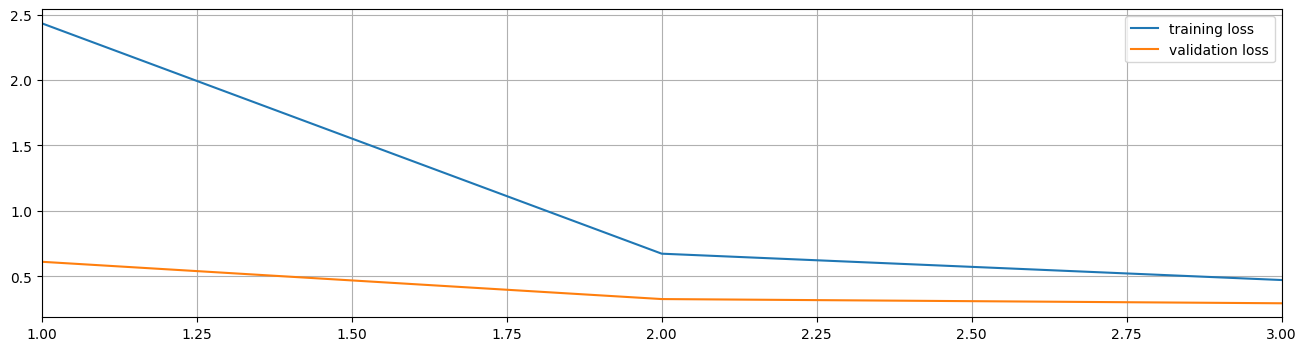

In [28]:
%%time
bs = 32
num_of_classes = len(i2c)

tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, num_of_classes)
freeze_to(resnet18, -1, True)

resnet18 = resnet18.cuda()

fit(resnet18, tr_dl, val_dl, epochs=3)

# Model by Noman

# Model by Vishal

# Model by Ayo